In [ ]:
# Danny Alvarez's CNN model. Meant to be run on Google Colab. 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import PIL
from PIL import Image

### Download Animal Images Dataset from Kaggle:

In [ ]:
# Fetch dataset from kaggle:
! pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json API key (kaggle.com -> Account -> API -> click "Create New API Token" -> run this code block and upload kaggle.json file)

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list    # Used to test if API is working. 

In [ ]:
! kaggle datasets download -d alessiocorrado99/animals10  # Download the dataset

 99% 581M/586M [00:02<00:00, 250MB/s]
100% 586M/586M [00:02<00:00, 251MB/s]


In [ ]:
! mkdir trainingdata
! unzip animals10.zip -d trainingdata   # Unzip dataset file

### Translate class names:

In [ ]:
# Code to translate Italian class names to English. If this code block does
# not work, try deleting Google Colab runtime and redownloading dataset.

# Italian to English translations (since dataset class names come in Italian):
ital_to_engl = {"cane": "dog",
                "cavallo": "horse", 
                "elefante": "elephant", 
                "farfalla": "butterfly", 
                "gallina": "chicken", 
                "gatto": "cat", 
                "mucca": "cow", 
                "pecora": "sheep", 
                "scoiattolo": "squirrel",
                "ragno": "spider"}

# Translate folder names from Italian to English:
for key in ital_to_engl:
  if os.path.exists("/content/trainingdata/raw-img/" + key):
    os.rename("/content/trainingdata/raw-img/" + key ,"/content/trainingdata/raw-img/" + ital_to_engl[key])

# Remove unneeded file:
if os.path.exists("/content/trainingdata/translate.py"):
  os.remove("/content/trainingdata/translate.py")
else:
  print("File does not exist.")

### Load dataset:

4863


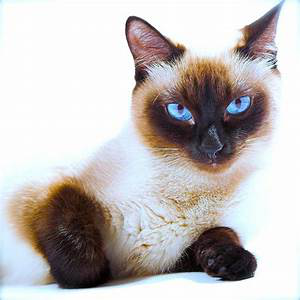

In [ ]:
# Remember - dataset contains .jpeg, .jpg, .png
dataset_dir = pathlib.Path("/content/trainingdata/raw-img")

# Testing viewing the dataset:
image_count = len(list(dataset_dir.glob("dog/*")))
print(image_count)    # Prints how many dog images there are.

kitties = list(dataset_dir.glob("cat/*"))
PIL.Image.open(str(kitties[0]))   # Displays first image in cats dataset.

In [ ]:
# define parameters for loader (resizes images as well):
batch_size = 32
img_height = 180
img_width = 180

# load training data:
training_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# load validation data:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

# load test data (split validation data into two datasets for 10% val, 10% test split):
val_batches = tf.data.experimental.cardinality(validation_ds)
#print(val_batches)
test_ds = validation_ds.take(val_batches // 2)
validation_ds = validation_ds.skip(val_batches // 2)
# print(tf.data.experimental.cardinality(test_ds))
# print(tf.data.experimental.cardinality(validation_ds))

class_names = training_ds.class_names
print(class_names)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


### Visualize some data:

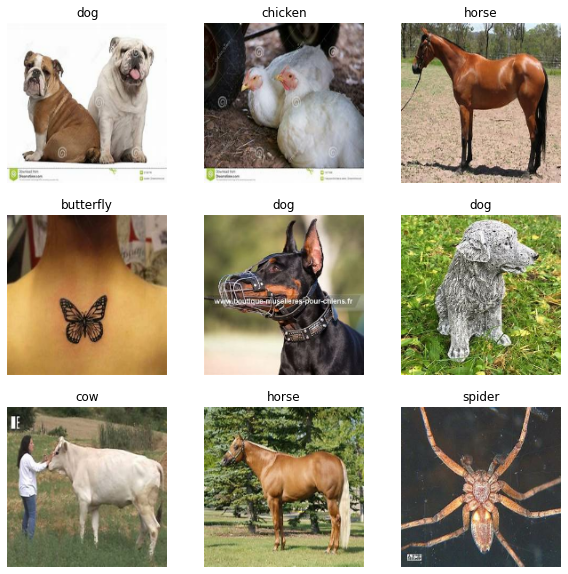

In [ ]:
# Visualize training set:
plt.figure(figsize = (10, 10))
for images, labels in training_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# # Visualize testing set:
# plt.figure(figsize = (10, 10))
# for images, labels in test_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# # Visualize validation set:
# plt.figure(figsize = (10, 10))
# for images, labels in validation_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Data Preprocessing:

### Normalization:
(Rescaling pixel values so they lie within a confined range (0-1))

In [ ]:
# Normalization layer (to be included in model):
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Configuring dataset for performance:

In [ ]:
# These help with performance during training (buffered prefetching).
# Dataset.cache keeps images in memory after they are loaded during first epoch.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().prefetch(buffer_size = AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Data Augmentation: (only do on training set)

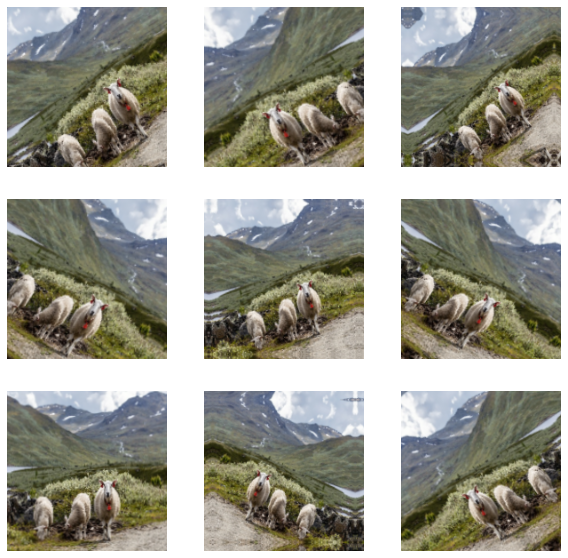

In [ ]:
# Define data augmentation layers (to be included in model later):
# Includes: flipping, zooming, rotation
data_aug_layers = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

# Visualize some augmented examples:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
  for i in range(9):
    augmented_images = data_aug_layers(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Building CNN Model:

In [ ]:
num_of_classes = len(class_names)

cnn_model = tf.keras.Sequential([
    normalization_layer,
    data_aug_layers,
    layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters = 256, kernel_size = 3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(num_of_classes, activation = "softmax")
])

In [ ]:
# Compile model:
cnn_model.compile(optimizer = "adam",
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"])

In [ ]:
# View all layers of network:
input_shape = (None, img_height, img_width, 3)
cnn_model.build(input_shape)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

## Training the Model:

In [ ]:
epochs = 30
history = cnn_model.fit(
    training_ds,
    validation_data = validation_ds,
    epochs = epochs
)

Epoch 1/30
655/655 [==============================] - 31s 31ms/step - loss: 1.9599 - accuracy: 0.2963 - val_loss: 1.7495 - val_accuracy: 0.3727
Epoch 2/30
655/655 [==============================] - 16s 25ms/step - loss: 1.5667 - accuracy: 0.4562 - val_loss: 1.5650 - val_accuracy: 0.4592
Epoch 3/30
655/655 [==============================] - 16s 25ms/step - loss: 1.3034 - accuracy: 0.5541 - val_loss: 1.2045 - val_accuracy: 0.5890
Epoch 4/30
655/655 [==============================] - 16s 24ms/step - loss: 1.1673 - accuracy: 0.6043 - val_loss: 1.1058 - val_accuracy: 0.6185
Epoch 5/30
655/655 [==============================] - 16s 25ms/step - loss: 1.0803 - accuracy: 0.6317 - val_loss: 1.0308 - val_accuracy: 0.6549
Epoch 6/30
655/655 [==============================] - 16s 24ms/step - loss: 1.0108 - accuracy: 0.6547 - val_loss: 0.9999 - val_accuracy: 0.6584
Epoch 7/30
655/655 [==============================] - 16s 24ms/step - loss: 0.9648 - accuracy: 0.6727 - val_loss: 1.0027 - val_accuracy:

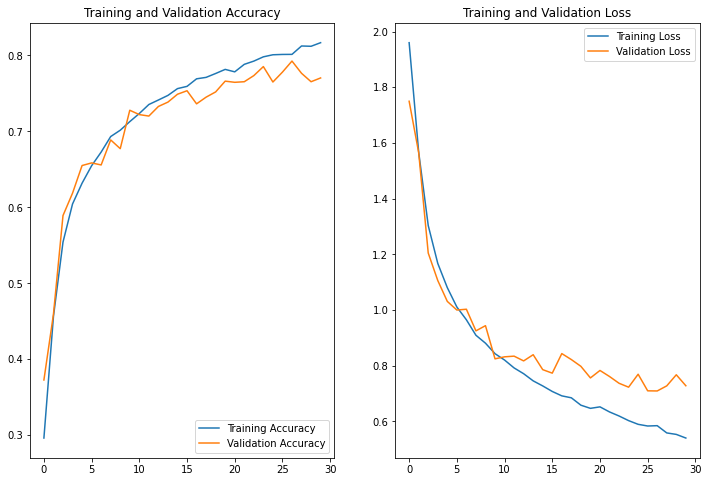

In [ ]:
# Visualize training results:
accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
validation_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation:

In [ ]:
results = cnn_model.evaluate(test_ds)
print("Test Loss, Test Accuracy:", results)

82/82 [==============================] - 1s 13ms/step - loss: 0.7219 - accuracy: 0.7793
Test Loss, Test Accuracy: [0.7219280004501343, 0.7793444991111755]
